### gradio가 잘되는지 테스트!

In [2]:
#!pip install gradio

In [ ]:
'''
import gradio as gr

# name을 받아서 Hello {name}! 을 출력
def greet(name):
    return "Hello " + name + "!"

# 데모 생성
demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch(share=True)
'''

### 웹앱만들기

#### 라이브러리 설치, 불러오기

In [4]:
#!pip install transformers

In [5]:
#!pip install faiss-cpu

In [64]:
#!pip install deepface

In [2]:
%matplotlib inline

In [6]:
from transformers import ViTModel

from PIL import Image
from torchvision.transforms import ToTensor

import torch

import numpy as np
import faiss
import matplotlib.pyplot as plt

from retinaface import RetinaFace

import gradio as gr

import cv2

#### 랜덤씨드 고정

In [7]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#### 주민 닮은꼴 찾기(함수 만들기)

In [8]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# 함수 정의하기

# ==========================================================
# 텍스트 파일 읽기
def read_txt_file(filename):
  f = open(filename, 'r')     # mode = 부분은 생략해도 됨
  str = f.read()

  return eval(str)


# ==========================================================
# 얼굴 자르기
def crop_face(img_path = "query_images/송가인.png"):
    try:
        faces = RetinaFace.extract_faces(img_path = img_path, align = True)
        face = faces[0]
        face = Image.fromarray(face)
    except:
        # face를 찾지 못하면 원본 이미지를 사용한다.
        face = Image.open(img_path)
    
    return face


# ==========================================================
def calculate(face):
    tf_toTensor = ToTensor()

    model.eval()
    input = tf_toTensor(face)

    with torch.no_grad():
        if input.shape[0] == 4:
            input = input[:3]
        latent_vector = model(input.unsqueeze(0).to(device), interpolate_pos_encoding=True)
        latent_vector = latent_vector['pooler_output'][0]

    return latent_vector

# ==========================================================
def get_result(latent_vector, k=3):
    distances, indexes = Index.search(latent_vector.cpu().unsqueeze(0), k)

    #print('distances:', distances)
    #print('indexes[0]:', indexes[0])

    result = []

    for idx in indexes[0]:
        file_name = file_name_lst[idx]
        #print(file_name)

        embedding_img_dir = "주민이미지/"
        input = Image.open(embedding_img_dir + file_name)
        #display(input)

        result.append(input)

    return result

# ==========================================================
# 알파 블렌딩
def show_blending_image(src1, src2_list):
    fig, axes = plt.subplots(3, 6, figsize=(20, 12), frameon=False)

    for j, src2 in enumerate(src2_list):
        alpha = 0.0
        src2 = np.array(src2)
        for i in range(6):
            beta = 1.0 - alpha
    
            src = cv2.addWeighted(src2, alpha, src1, beta, 0)
            alpha += 0.2
            axes[j, i].imshow(src)
            axes[j, i].axis('off')

    return fig

In [10]:
# 파일 이름 불러오기
file_name_lst = read_txt_file('file_name_lst.txt')

In [11]:
# 유사도 계산하기
# 저장한 임베딩 벡터 불러오기
animal_data = np.load('animal_data.npy', allow_pickle=True)
animal_data.shape

# 인덱스 추가하기
Index = faiss.IndexFlatL2(animal_data.shape[1])
# print(Index.is_trained)		# True
Index.add(animal_data)
# print(Index.ntotal)

In [12]:
def predict(img_path):
    # 얼굴 크롭한 사진을 이용
    face = crop_face(img_path)
    
    latent_vector = calculate(face)
    result = get_result(latent_vector, 3)

    # 결과물을 시각화 하기 
    src1 = cv2.resize(np.array(face), dsize=(128,128))
    src2 = np.array(result[0])
    # blending_image = show_blending_image(src1, src2)
    blending_image = show_blending_image(src1, result)

    file_path = "test.jpg"
    blending_image.tight_layout()
    blending_image.savefig(file_path)
    
    return file_path

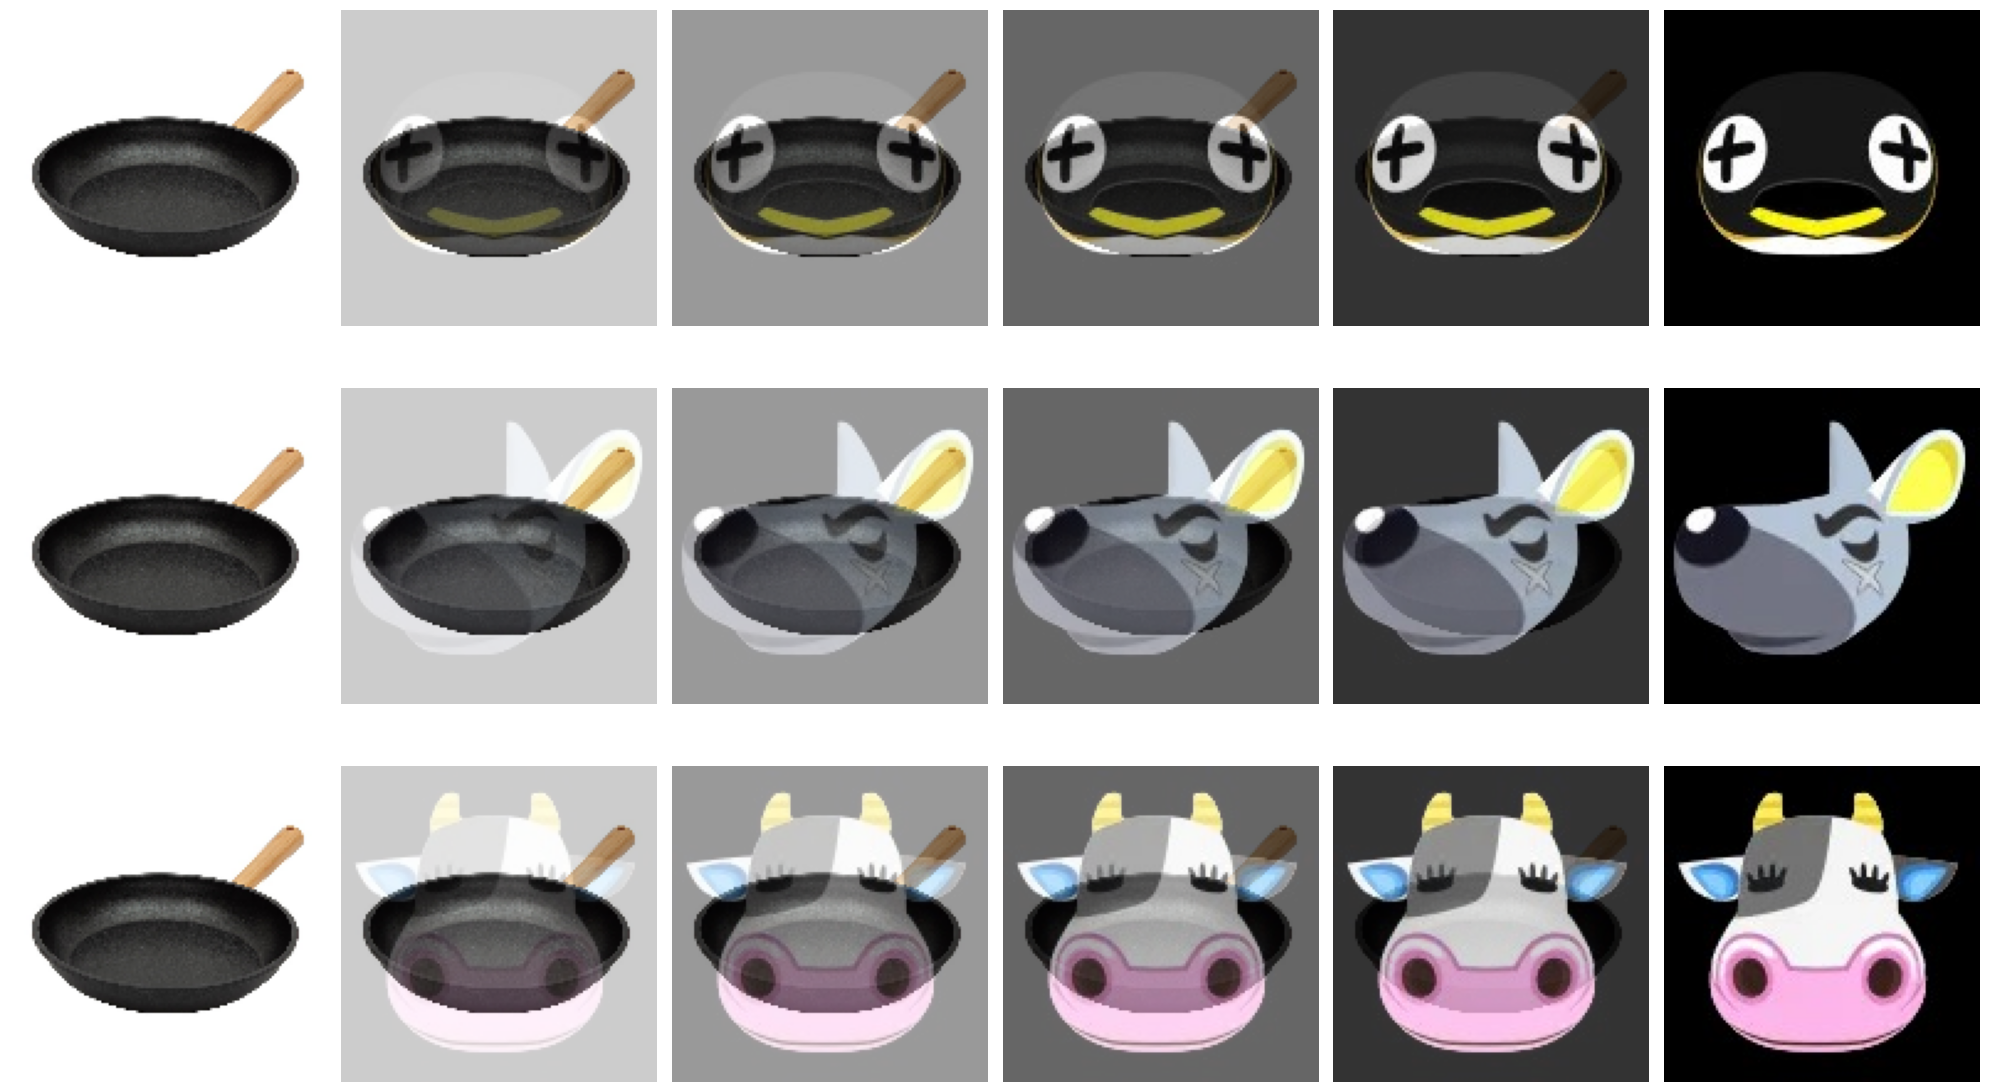

In [13]:
img_path = "./후라이팬.jpg"

result = predict(img_path)


In [14]:
import gradio as gr

demo = gr.Interface(fn=predict, inputs=[gr.Image(type="filepath")], outputs='image')
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7870
Running on public URL: https://8f8a2635712b38c7b2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
